<a href="https://colab.research.google.com/github/smartgeometry-ucl/COMP0169-2021-CourseWorks/blob/master/CW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 1: Learning Learning, From Scratch
_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Luca Morreale, Pradyumna Reddy, Sanjeev Muralikrishnan & Animesh Karnewar__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission:

Coursework submissions must comprise of this **single** jupyter notebook, containing your code and written comments. Cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.

Note: The `optimize` module from `scipy` can only be used for the question where it is specified, and not anywhere else.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): Free form optimization (18 points)

[Question 3](#question3): Clustering (14 points)

[Question 4](#question4): Linear Classification (18 points)

[Question 5](#question5): Non-linear Classification (20 points)

[Question 6](#question6): Neural Networks (20 points)

## Datasets

We will be using two datasets for the whole coursework: _IRIS_ and _MNIST_. Both datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits. The features of each image are the pixels themselves.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

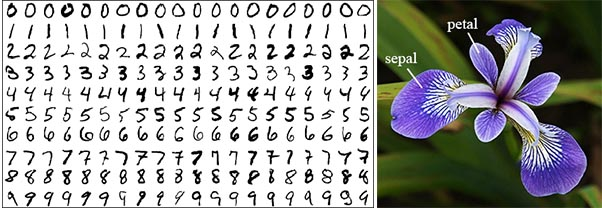

## Packages

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
# Importing packages
import numpy as np
import random

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test

#end_test


## Data Loading

The following cells are used to load both datasets, _Iris_ and _MNIST_.

In [3]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [4]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [5]:
def plot_dataset(X, Y, dims=[0,1]):
    # Keep only two dimensions
    X_reduced = X[:, dims]
    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Feat 1')
    plt.ylabel('Feat 2')
    plt.show()

In [6]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [7]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if len(titles) == n_rows*n_columns:
          plt.title(titles[i])
    plt.show()

In [8]:
def plot_loss_curve(logs):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(logs)
    plt.show()

In [9]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [10]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ dataset

In [11]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1.a**
<a name='question1a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [12]:
def nsolve(X,y):
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights 
    """

    #begin_solution
    #formula from course
    w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),y)
    #end_solution


    return w

Testing your code on mockup data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [13]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution
#we check if we have random data that define points on a line, then the estimate line is the correct one
X_random = np.random.rand(4,3)
w_random = np.random.rand(3,1)
y_calculated = np.dot(X_random,w_random)
np.allclose(w_random,nsolve(X_random,y_calculated))
#end_solution


True

**Question 1.b**
<a name='question1b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [14]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """

    #begin_solution
    #we add the bias for each data point
    n,m = X.shape
    X0 = np.ones((n,1))
    X = np.hstack((X,X0))
    #we use nsolve
    w = nsolve(X,y)
    #we calculate l2 error
    l2_error = np.linalg.norm(y - np.dot(X,w), 2) 
    #end_solution

    return w, l2_error

Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [15]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution
#we test line fit for the iris training set, we need to remove the third feature, because that is the result we try to estimate
y_line_fit = X_iris[:,2]
X_line_fit = np.delete(X_iris, 2, axis=1)
w_line_fit, l2_line_fit = line_fit(X_line_fit,y_line_fit)
print(l2_line_fit)
#end_solution


3.534583205431446


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [16]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution
#we test line fit for the iris test set, we need to remove the third feature, because that is the result we try to estimate
y_test_line_fit = X_iris_test[:,2]
X_test_line_fit = np.delete(X_iris_test, 2, axis=1)
w_test_line_fit, l2_test_line_fit = line_fit(X_test_line_fit,y_test_line_fit)
print(l2_test_line_fit)
#end_solution


1.278233599495976


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

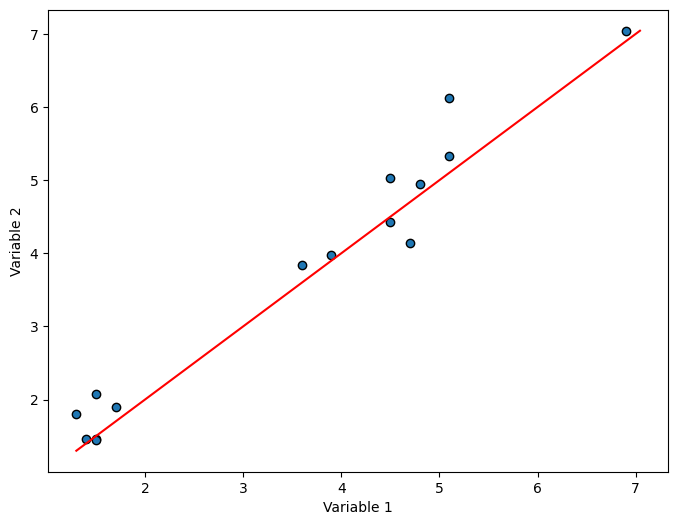

In [17]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
#we add the bias for the test data and we use the estimated w from the training data to compare the true values with the estimated ones
n,m = X_test_line_fit.shape
X0_test_line_fit = np.ones((n,1))
X1_test_line_fit = np.hstack((X_test_line_fit,X0_test_line_fit))
plot_correlation(y_test_line_fit,np.dot(X1_test_line_fit,w_line_fit))
#end_solution


In [18]:
#begin_test

#end_test


**Question 1.c**
<a name='question1c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """
    #begin_solution
    #we add the bias
    n,m = X.shape
    X0 = np.ones((n,1))
    X = np.hstack((X,X0))
    X1 = np.zeros((n,(m+2)*(m+1)//2))
    n1,m1 = X1.shape
    #we create all combination of two columns from X the data in order to obtain the second degree polynomial
    for index,x in enumerate(X):
        jindex = 0
        for j in range(m+1):
            for k in range(j,m+1):
                X1[index][jindex] = x[j]*x[k]
                jindex = jindex+1
    w = nsolve(X1,y)
    l2_error = np.linalg.norm(y - np.dot(X1,w), 2) 
    #end_solution

    return w, l2_error

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [20]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution
#we test polynomial fit for the iris training set, we need to remove the third feature, because that is the result we try to estimate
y_poly_fit = X_iris[:,2]
X_poly_fit = np.delete(X_iris, 2, axis=1)
w_poly_fit, l2_poly_fit = poly_fit(X_poly_fit,y_poly_fit)
print(l2_poly_fit)
#end_solution


3.1423820050244604


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [21]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution
#we test polynomial fit for the iris test set, we need to remove the third feature, because that is the result we try to estimate
y_test_poly_fit = X_iris_test[:,2]
X_test_poly_fit = np.delete(X_iris_test, 2, axis=1)
w_test_poly_fit, l2_test_poly_fit = poly_fit(X_test_poly_fit,y_test_poly_fit)
print(l2_test_poly_fit)
#end_solution


0.916436321236914


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

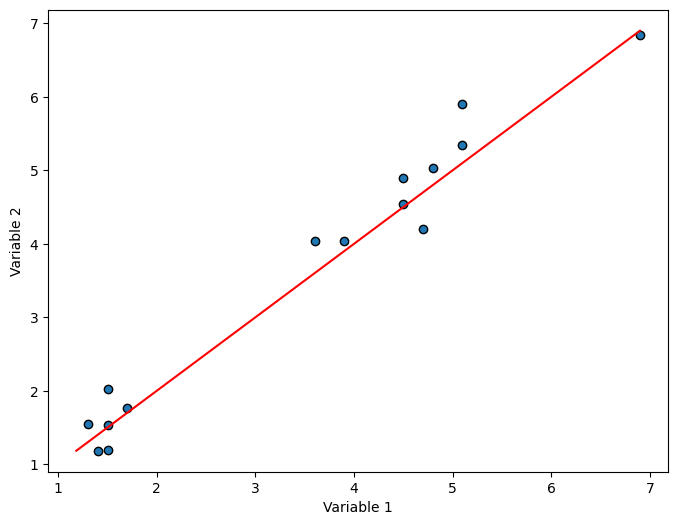

In [22]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution
#we construct the second degree polynomial and we use the estimated w from the training data to compare the true values with the estimated ones
n,m = X_test_poly_fit.shape
X0_test_poly_fit = np.ones((n,1))
X_test_poly_fit = np.hstack((X_test_poly_fit,X0_test_poly_fit))
X1_test_poly_fit = np.zeros((n,(m+2)*(m+1)//2))
n1,m1 = X1_test_poly_fit.shape
for index,x in enumerate(X_test_poly_fit):
    jindex = 0
    for j in range(m+1):
        for k in range(j,m+1):
            X1_test_poly_fit[index][jindex] = x[j]*x[k]
            jindex = jindex+1
#we use
plot_correlation(y_test_poly_fit,np.dot(X1_test_poly_fit,w_poly_fit))
#end_solution


In [23]:
#begin_test

#end_test


## 2. Free form optimization (18 points)
<a name='question2'></a>

[a)](#question2a) Implement Gradient Descent (GD) (**3 points**), Gradient Descent with Nesterov Momentum (GDN)  (**4 points**) and a second order optimization method (**4 points**)

[b)](#question2b) Write the gradient and hessian of "paraboloid" and run the optimization methods on it (**7 points** on hidden test)

**Question 2.a**
<a name='question2a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [24]:
def gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change=1.0e-6):
    """
    Write your own implementation of gradient descent here.
    
    Arguments:
    
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    #begin_solution
    dif = eps_change+1
    #we apply gradient descent either until we get to the maximum number of steps, or until the difference is smaller than a certain epsilon
    while(current_it < max_iterations and dif > eps_change):
        initial_solution = objective(parameters)
        #the parameters move opposite to the gradient
        new_parameters = parameters - step_size*d_objective(parameters)
        new_solution = objective(new_parameters)
        dif = abs(new_solution-initial_solution)
        #we keep only the solution that minimizes the objective funtion
        if(new_solution<initial_solution):
            minimizer = new_parameters.copy()
        parameters = new_parameters.copy()
        current_it = current_it+1
    current_it = current_it - 1
    #end_solution
    
    return minimizer, current_it + 1
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [25]:
def gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change):
    """
    Write your own implementation of gradient descent with Nesterov momentum here.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     derivative of the function to minimize - R^N -> R^N
    momentum:        weight of the momentum term - R^1
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    initial_speed = np.zeros(N)
    
    dif = eps_change+1
    #we apply gradient descent either until we get to the maximum number of steps, or until the difference is smaller than a certain epsilon
    while(current_it < max_iterations and dif > eps_change):
        initial_solution = objective(parameters)
        #we use the formulas in order to calculate the new parameters, while still using information about past values of the gradient
        nesterov_parameters = parameters + momentum*initial_speed
        new_speed = momentum*initial_speed - step_size*d_objective(nesterov_parameters)
        new_parameters = parameters + new_speed
        new_solution = objective(new_parameters)
        dif = abs(new_solution-initial_solution)
        if(new_solution<initial_solution):
            minimizer = new_parameters.copy()
        parameters = new_parameters.copy()
        initial_speed = new_speed.copy()
        current_it = current_it+1
    current_it = current_it - 1

    #end_solution

        
    return minimizer, current_it + 1
    

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [26]:
def second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change):
    """
    Write your own implementation of a second order optimizer.
    
    Arguments:
    parameters:      init of parameters to optimize - R^N
    objective:       function to minimize - R^N -> R^1
    d_objective:     function computing the derivative of the objective - R^N -> R^N
    dd_objective:    function computing the second derivative of the objective - R^N -> R^NxN
    step_size:       step size/learning rate for the optimization algorithm - R^1
    max_iterations:  maximum number of iterations to run the optimization algorithm - R^1 integer
    eps_change:      minimum change of minimizer one step to the next before stopping - R^1
    
    Return:
    minimizer:    solution of the optimization
    current_it:   iteration number at which the optimization reached the minimum
    """
    
    N          = parameters.shape[0]
    minimizer  = parameters.copy()
    current_it = 0
    
    #begin_solution
    dif = eps_change+1
    while(current_it < max_iterations and dif > eps_change):
        #we apply gradient descent either until we get to the maximum number of steps, or until the difference is smaller than a certain epsilon
        initial_solution = objective(parameters)
        #we use a second order optimization (we basically use the order 2 terms in the Taylor expansion)
        new_parameters = parameters - np.dot(np.linalg.inv(dd_objective(parameters)),d_objective(parameters))
        new_solution = objective(new_parameters)
        dif = abs(new_solution-initial_solution)
        if(new_solution<initial_solution):
            minimizer = new_parameters.copy()
        parameters = new_parameters.copy()
        current_it = current_it+1
    current_it = current_it - 1
    #end_solution

    return minimizer, current_it + 1
    

In [27]:
def square(X):
    return np.power(X, 2).sum()

def d_square(X):
    return 2 * X

def dd_square(X):
    hessian = np.eye(X.shape[0]) * 2
    return hessian


In [28]:
best_parameters_gradient_descent, nr_steps_gradient_descent = gradient_descent(np.array([3,1,2]),square,d_square,0.1,100,0)
print(best_parameters_gradient_descent, nr_steps_gradient_descent, square(best_parameters_gradient_descent))

best_parameters_gradient_descent_nesterov, nr_steps_gradient_descent_nesterov = gradient_descent_nesterov(np.array([3,1,2]),square,d_square,0.4,0.1,100,0)
print(best_parameters_gradient_descent_nesterov, nr_steps_gradient_descent_nesterov, square(best_parameters_gradient_descent_nesterov))

best_parameters_gradient_descent_order2, nr_steps_gradient_descent_order2 = second_order(np.array([3,1,2]),square,d_square,dd_square,0.1,100,0)
print(best_parameters_gradient_descent_order2, nr_steps_gradient_descent_order2, square(best_parameters_gradient_descent_order2))

[6.11110793e-10 2.03703598e-10 4.07407195e-10] 100 5.8093217964334e-19
[1.59757594e-24 5.32525314e-25 1.06505063e-24] 100 3.970164935916114e-48
[0. 0. 0.] 2 0.0


**Question 2.b**
<a name='question2b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [29]:
def paraboloid(X): # paraboloid or saddle function X[0]^2-X[1]^2+X[2]^2 ... 
    tmp = np.power(X, 2)
    return tmp[0::2].sum() - tmp[1::2].sum()

def d_paraboloid(X):
    gradient = np.zeros(X.shape[0])
    #begin_solution
    for index,x in enumerate(X):
        gradient[index] = 2*x
        if(index%2 != 0):
            gradient[index] = gradient[index]*(-1)
    #end_solution

    return gradient

def dd_paraboloid(X):
    hessian = np.eye(X.shape[0])
    #begin_solution
    for index,row in enumerate(X):
        if(index%2 == 0):
            hessian[index][index] = 2
        else:
            hessian[index][index] = -2
    #end_solution

    return hessian

In [30]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [31]:
parameters     = np.ones(1)
objective      = square
d_objective    = d_square
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer, gd_it = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change)

#begin_test
print(gd_minimizer, gd_it, square(gd_minimizer))
#end_test

parameters     = np.ones(1)
objective      = square
d_objective    = d_square
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

nesterov_minimizer, nesterov_it = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)

#begin_test
print(nesterov_minimizer, nesterov_it, square(nesterov_minimizer))
#end_test

parameters     = np.ones(1)
objective      = square
d_objective    = d_square
dd_objective   = dd_square
step_size      = 1.0
max_iterations = 200
eps_change     = 1.0e-6

second_minimizer, second_it = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)

#begin_test
print(second_minimizer, second_it, square(second_minimizer))
#end_test



[0.00123794] 30 1.5324955408658897e-06
[0.0003919] 15 1.5358687424352327e-07
[0.] 2 0.0


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [32]:
parameters     = np.array([3,1,2])
objective      = paraboloid
d_objective    = d_paraboloid
dd_objective   = dd_paraboloid
momentum       = 0.4
step_size      = 0.1
max_iterations = 100
eps_change     = 1.0e-6

gd_minimizer_paraboloid, gd_it_paraboloid = gradient_descent(parameters, objective, d_objective, step_size, max_iterations, eps_change) 

#begin_test
print(gd_minimizer_paraboloid, gd_it_paraboloid, paraboloid(gd_minimizer))

nesterov_minimizer_paraboloid, nesterov_it_paraboloid = gradient_descent_nesterov(parameters, objective, d_objective, momentum, step_size, max_iterations, eps_change)
print(nesterov_minimizer_paraboloid, nesterov_it_paraboloid, paraboloid(nesterov_minimizer_paraboloid))

second_minimizer_paraboloid, second_it_paraboloid = second_order(parameters, objective, d_objective, dd_objective, step_size, max_iterations, eps_change)
print(second_minimizer_paraboloid, second_it_paraboloid, paraboloid(second_minimizer_paraboloid))
    
#end_test


[6.11110793e-10 8.28179745e+07 4.07407195e-10] 100 1.5324955408658897e-06
[1.59757594e-24 6.84982354e+11 1.06505063e-24] 100 -4.6920082547784234e+23
[0. 0. 0.] 2 0.0


In [33]:
#begin_test

#end_test


## 3. Clustering (14 points)
<a name='question3'></a>

[a)](#question3a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset, which is composed of 10 digit classes. Display the top 10 components fitted on the train dataset as images. Next, check that you can reconstruct perfectly an input digit from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**3 points** + **4 points** on hidden dataset)

[b)](#question3b) Perform independent research on the clustering algorithm k-means. Implement a function kmeans performing k-means on input data X. Propose the interface to that function (i.e., what is its input and output?) and write in three sentences why this is. Apply you kmeans implementation on the _MNIST_ training set with k= 10 clusters and display the centroids as images. (**2 points** + **3 points** on hidden dataset)

[c)](#question3c) Describe the k-means algorithm, highlighting similarities and differences from PCA. Compare the reconstruction loss on the validation set for both k-means and PCA. Write no more than ten sentences. (**2 points**)

**Question 3.a**
<a name='question3a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [34]:
def pca(X, ndims):
    """
    Write your implementation of PCA here.

    Arguments:
    X : Data matrix
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    n,m = X.shape
    avg = np.zeros([1,m])
    #we calculate the data mean 
    for j in range(m):
        sum = 0;
        for i in range(n):
            sum = sum + X[i,j]
        avg[0,j] = sum / n
    #we substract the average from the matrix
    h = np.ones([n,1])
    B = X - np.dot(h,avg)
    #we calculate the covariance matrix
    C = np.dot(B.T,B)
    C = C/(n-1)
    #we calculate the eigenvalues and eigenvectors of the covariance matrix, and we order them in decreasing order
    eigenvalues,eigenvectors = np.linalg.eig(C)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    mean_vec=avg
    #we only keep the first "ndims" eigenvectors
    top_eig_vecs = eigenvectors[:,:ndims]

    #end_solution


    return mean_vec, top_eig_vecs

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

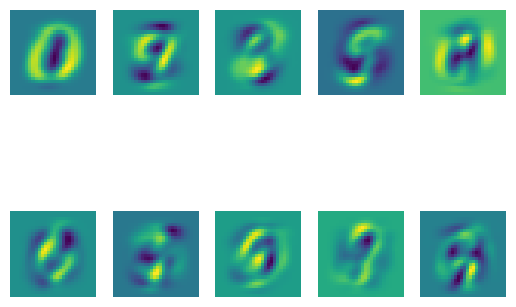

In [35]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.
"""

#begin_solution
mean, eigenvectors = pca(X_mnist,10)
plot_eigenvecs(eigenvectors.T,2,5)
#end_solution


In [36]:
#begin_test

#end_test


Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [37]:
def pca_projection(X, mean_vec, eig_vecs):
    """
    Write your implenetation of PCA projection here.

    Arguments:
    X : Data matrix
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector

    Returns:
    weights : Weights corresponding to the eigen vectors
    """

    #begin_solution
    n,m = X.shape
    h = np.ones([n,1])
    #we project the matrix obtained after substracting the mean onto the eigenvectors
    B = X - np.dot(h,mean_vec)
    weights = np.dot(B,eig_vecs)
    #end_solution


    return weights

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [38]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
    """
    Write your implementation of PCA reconstruction here.

    Arguments:
    weights : Weights obtained from pca_projection
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector
    """

    #begin_solution
    n,m=weights.shape
    h = np.ones([n,1])
    avg = np.dot(h,mean_vec)
    #we reconstruct the image and we add the mean
    B = np.dot(weights,eig_vecs.T)
    reconstruction = B+avg
    #end_solution


    return reconstruction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

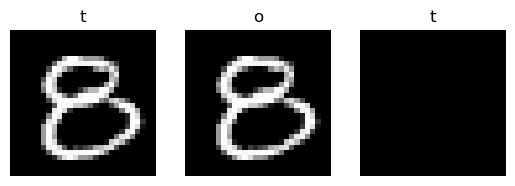

In [39]:
"""
Below, 
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the 
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution

mean, eigenvectors = pca(X_mnist,784)
weights = pca_projection(np.array([X_mnist[0]]),mean,eigenvectors)
X0_reconstructed = pca_reconstruction(weights,mean,eigenvectors)
dif = X_mnist[0] - X0_reconstructed[0]
plot_grey_image(np.array([X_mnist[0],X0_reconstructed[0],dif]),1,3,"tot")
#end_solution


**Question 3.b**
<a name='question3b'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_
The parameters of the functions should be:<br>
    A data matrix that describe the objects -> an n*m matrix where n is the number of objects and m is the nubmer of characteristics of each object, <br>
    An integer k that sets the number of clusters (categories) that we want to split our objects into, <br>
    An integer max_iterations that sets an alternative stopping condition, namely the maximum number of steps that we let our method run

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [40]:
#begin_test

#end_test


In [41]:
def kmeans(X, k, max_iterations=100):
    """
    Write your implementation of kmeans here.

    Arguments:
    X : Data matrix.
    k : Your choise of k, an integer.
    max_iterations : The number of iterations after which to stop.

    Returns:
    centroids: The learned cluster centroids.
    """

    #begin_solution
    # we initialize the centroids as the average of already existing points, we split them in groups of approximately the same size
    n,m = X.shape
    average_centroids_size = n//k 
    centroids = np.zeros([k,m])
    for i in range(k-1):
        for j in range(average_centroids_size):
            element = X[i*average_centroids_size+j]
            centroids[i] = centroids[i] + element
        centroids[i] = centroids[i]/average_centroids_size
    nr=0
    for t in range(i*average_centroids_size+j+1,n):     
        nr = nr + 1  
        element = X[t]
        centroids[k-1] = centroids[k-1] + element
    centroids[k-1] = centroids[k-1]/nr
    # we start to apply the algorithm
    for iteration in range(max_iterations):
        new_centroids = np.zeros([k,m])
        nr_elements = np.zeros([k])
        #for each data point, we search the centroid that is closest to it, and we asign that centroid to that data point
        #we also calculate new centroids, as the average of all the data points that have been assigned to it
        for element in range(n):
            min_centroid = 0;
            minimum = np.linalg.norm((X[element]-centroids[0]),2)
            for t in range(1,k):
                dif = np.linalg.norm((X[element]-centroids[t]),2) 
                if(dif<minimum):
                    minimum = dif
                    min_centroid = t
            new_centroids[min_centroid] = new_centroids[min_centroid] + X[element]
            nr_elements[min_centroid] = nr_elements[min_centroid] + 1
        for t in range(k):
            if(nr_elements[t]):
                centroids[t] = new_centroids[t] / nr_elements[t]
    #end_solution


    return centroids


Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

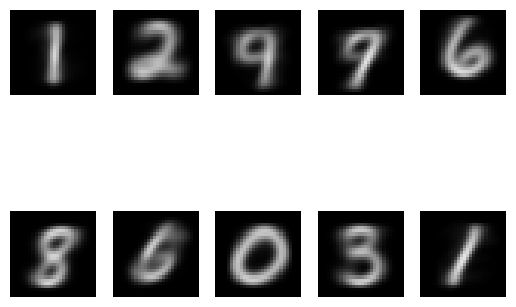

In [42]:
"""
Below, test your kmeans on the MNIST dataset.
For all 10 digits, plot and display the cluster centroids as an image grid. 
Use provided plotting functions.
"""

#begin_solution
MNIST_train_centroids = kmeans(X_mnist,10)
plot_grey_image(MNIST_train_centroids, 2, 5, "title")
#end_solution


**Question 3.c**
<a name='question3c'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:
In K-means algorithm we attempt to cluster points together by assigning them to k "centroids", k being a hyperparameter of the method, one that gives us how many classes we want to group our data points in. Those centroids are initialized as random data points, from the ones given. Then, the algorithm groups all the data points into k groups, by assigning each data points to the closest centroid. The distance is the L2(Euclidean) norm, used for points in R^n. Once all the data points have been assigned to clusters, we recalculate the (pixelwise) mean of the images for each cluster, and we get new centroids. These two operations are repeated, either untill the assignments don't change between 2 consecutive iterations, or until the max number of iterations has been reached. In PCA, we search for the eigenvectors that cause the most "difference" between data points, splitting on those maximizes distance between clusters, by only considering several dimensions, we eliminate the dimensions with small relative variance, therefore focusing only on the features that are key in deciding between clusters. Kmeans actually does the clustering, while PCA can be used either as a preprocessing step, in order to find the direction that the split should happen, or as a postprocessing step in order to help with the visualisation of the data. It is hard to imagine points in R^n, but reducing to R^3 or R^2 could be helpful as long as the coordinates that are most importing in telling clusters apart, are taken as the dimensions that are plotted.

In [43]:
#begin_test
#end_test


## 4. Linear Classification (18 points)
<a name='question4'></a>

[a)](#question4a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**3 points**)
Test this on all the samples in _IRIS_, Setosa vs non-Setosa, etc and propose a simple analysis (text, figure, table) of the result you find, but not longer than ten sentences. (**4 points** on hidden dataset)

[b)](#question4b) Perform independent research how to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**5 points** + **6 points** on hidden dataset)
Present findings applying multi-class classification on _IRIS_ dataset with 3 classes. You can include figures and tables if needed. Write no longer than ten sentences.

**Question 4.a**
<a name='question4a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [67]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """

    #begin_solution
    #we create the labels for the training data
    nA,mA = examplesA.shape
    nB,mB = examplesB.shape
    X_train = np.concatenate((examplesA, examplesB), axis=0)
    Y_train = np.concatenate((np.zeros([nA, 1]), np.ones([nB,1])), axis=0)
    # we calculate the estimated w
    w_trained,l2_error = line_fit(X_train,Y_train)
    
    nT,mT = testExample.shape
    testExample = np.hstack((testExample,np.ones((nT,1))))
    preds = np.zeros(nT)
    #we calculate the estimated values for the testing data, if they are closer to 1, then they have label 1, 0 otherwise
    for (index,x) in enumerate(testExample):
        est = np.dot(x,w_trained)
        print(est)
        if(est>=0.5):
            preds[index] = 1
        else:
            preds[index] = 0
    
    #end_solution  
    return preds

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [68]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#begin_solution
X_Iris_Setosa = []
X_Iris_Non_Setosa = []
#we need to construct the training data, the data in the class is the data labeled with 0(iris setosa), and the data not in the 
#class is the data labeled with 1 or 2
for (index, y) in enumerate(Y_iris):
    if (y==0):
        X_Iris_Setosa.append(X_iris[index].tolist())
    else:
        X_Iris_Non_Setosa.append(X_iris[index].tolist())

sols = lclass(np.array(X_Iris_Setosa), np.array(X_Iris_Non_Setosa), X_iris_test)
print(sols)
#end_solution


[0.93039872]
[-0.0145134]
[1.43898423]
[0.87691637]
[0.92490999]
[0.06055367]
[0.68625953]
[0.94725552]
[1.04324715]
[0.7902923]
[0.93077075]
[0.15789002]
[-0.02285944]
[0.15011878]
[-0.02888805]
[1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

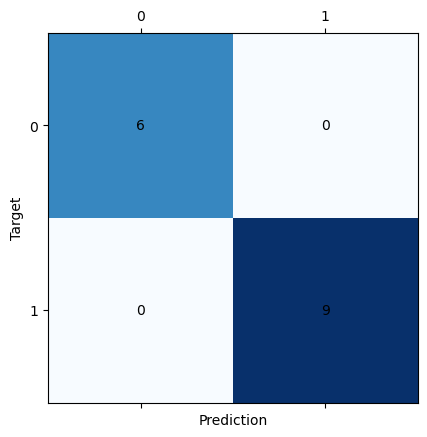

In [69]:
"""
Below, plot and display the confusion matrix of your prediction with respect to 
true values. Use provided functions for plotting.
"""

#begin_solution
###############
Y_iris_binary_classifier_test = Y_iris_test.copy()
#we plot the confusion matrix between the data we obtained, and the data we should have obtained, note that we merge the 
#1 and 2 class, as our classifier is binary, it only tells the difference between the 0-class and the others
for (index,y) in enumerate(Y_iris_test):
    if(y==2):
        Y_iris_binary_classifier_test[index] = Y_iris_binary_classifier_test[index]-1
plot_confusion_matrix(sols,Y_iris_binary_classifier_test)
#end_solution


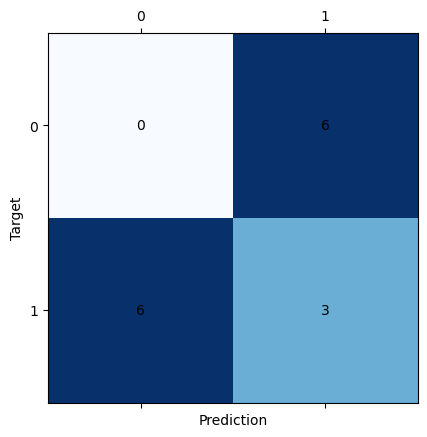

In [70]:
#begin_solution
###############
Y_iris_binary_classifier_test = Y_iris_test.copy()
#we plot the confusion matrix between the data we obtained, and the data we should have obtained, note that we merge the 
#0 and 2 class, as our classifier is binary, it only tells the difference between the 1-class and the others
for (index,y) in enumerate(Y_iris_test):
    if(y==1):
        Y_iris_binary_classifier_test[index] = Y_iris_binary_classifier_test[index]-1
    else:
        Y_iris_binary_classifier_test[index]=1
plot_confusion_matrix(sols,Y_iris_binary_classifier_test)
#end_solution

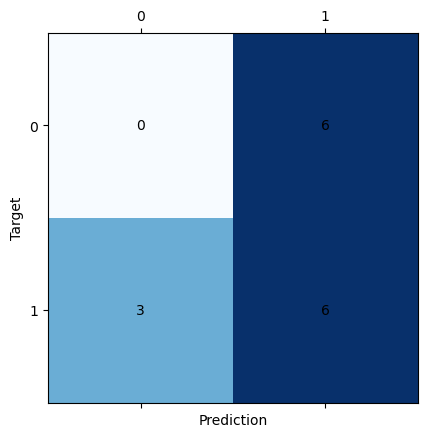

In [72]:
#begin_solution
###############
Y_iris_binary_classifier_test = Y_iris_test.copy()
#we plot the confusion matrix between the data we obtained, and the data we should have obtained, note that we merge the 
#0 and 1 class, as our classifier is binary, it only tells the difference between the 2-class and the others
for (index,y) in enumerate(Y_iris_test):
    if(y==2):
        Y_iris_binary_classifier_test[index] = 0
    else:
        Y_iris_binary_classifier_test[index]=1
plot_confusion_matrix(sols,Y_iris_binary_classifier_test)
#end_solution

In [71]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ 
Analyzing the result above, we can state that the Setosa class is linearly separable from the rest of the classes. If we further look into the actual results of the classifiers, we see that the test data gives comprehensive results when using the w obtained from the training data. We know that the prediction is more "sure" that the result is right, the further the result is to the decision boundary (which I set at 0.5, the mean of 0 and 1). Out of the 15 test samples, only 2 are relatively close to 0.5
However, running the same algorithm for the other two classes leads to poor results. That means that the two classes denoted with 1 and 2 are not linearly separable.

**Question 4b**
<a name='question4b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [48]:
def softmax(preds):
    """
    Write your implementation of the softmax activation here.

    Arguments:
    preds : The output predicted classes from your classifier

    Returns:
    activation : The outputs after applying softmax activation
    """

    #begin_solution
    exp_preds = np.exp(preds)
    exp_sum = np.sum(exp_preds)
    activation = exp_preds/exp_sum
    #end_solution
    
    return activation

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [49]:
def lclass_prob(examplesA, examplesB, testExample):
    """
    Write your implementation of lclass_prob here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted probabilities of samples in testExample belonging to a class.
    """
    
    #begin_solution
    #we have a binary classifier, that tells us wheter data points are in category A, case in which the output is 1, or in B, case in which the output is 0
    nA,mA = examplesA.shape
    nB,mB = examplesB.shape
    X_train = np.concatenate((examplesA, examplesB), axis=0)
    Y_train = np.concatenate((np.ones([nA, 1]), np.zeros([nB,1])), axis=0)
    #we get the trained w by using the line fit
    w_trained,l2_error = line_fit(X_train,Y_train)
    #we calculate the expected value for the test data. The higher the value, the greater the probability of the test data point to be in category A
    nT,mT = testExample.shape
    testExample = np.hstack((testExample,np.ones((nT,1))))
    preds = np.zeros(nT)
    for (index,x) in enumerate(testExample):
        est = np.dot(x,w_trained)
        preds[index] = est
    #end_solution

    
    return preds

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [50]:
def lmclass(examples, labels, testExample):
    """
    Write your implementation of multiclass classifier lmclass here.
    Use your lclass_prob implementation here to solve this.

    Arguments:
    examples : The training data matrix
    labels : The training labels
    testExample : The testing data matrix

    Returns:
    preds_prob : For each sample in testExample, their predicted probabilities
                 of belonging to each class
    """

    #begin_solution
    nr_classes = 0
    more_classes = 1
    nT,mT = testExample.shape
    preds_prob = np.empty((0,nT))
    #for each class, we separate the test data in 2 categories, the first one are the elements in the class, the second one are the elements not in the class
    while(more_classes):
        more_classes = 0
        X_In_Category = []
        X_Not_In_Category = []
        for (index,x) in enumerate(examples):
            if(labels[index] == nr_classes):
                X_In_Category.append(x.tolist())
            elif(labels[index] == nr_classes+1):
                X_Not_In_Category.append(x.tolist())
                more_classes = 1
            else:
                X_Not_In_Category.append(x.tolist())
        #we run the binary classifier for each class, this gives us a number that shows the "probability" that the data point is in that category.
        prob = lclass_prob(np.array(X_In_Category),np.array(X_Not_In_Category),testExample)
        nr_classes = nr_classes + 1
        preds_prob = np.vstack((preds_prob,prob))
    #the preds_prob matrix has nT lines -> the number of classes, and mT columns -> the number of test data points
    nT,mT = preds_prob.shape
    #each column represents the "probability" of one data point belonging to one of the classes 
    #we use softmax to transform the values that show the "probabilities" of each test data to be part of a certain class, into real probabilities
    for i in range(mT):
        column = preds_prob[:,i]
        normalized_column = softmax(column)
        preds_prob[:,i]=normalized_column 
    
    #end_solution
    return preds_prob.T

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [51]:
#begin_solution
prob = lmclass(np.array(X_iris),np.array(Y_iris),X_iris_test)
print(prob)
print(Y_iris_test)
correct = 0 
#for each data point, we say that the class that the test data point belongs to is the class that gave the highest probability for the binary classsifier
for (i,test) in enumerate(prob):
    maxx = 0
    maxxindex = 0
    for (index,x) in enumerate(test):
        if(x>maxx):
            maxx = x
            maxxindex = index
    print(maxxindex)
    if(maxxindex==Y_iris_test[i]):
        correct = correct+1;
#we calculate our accuracy
accuracy = correct / len(Y_iris_test)
print(accuracy)
#end_solution


[[0.24912843 0.4389544  0.31191718]
 [0.58138145 0.21323566 0.2053829 ]
 [0.1353106  0.39795294 0.46673646]
 [0.26714452 0.35335302 0.37950246]
 [0.25259119 0.4083971  0.33901171]
 [0.55328185 0.23775947 0.20895869]
 [0.3267308  0.32629182 0.34697738]
 [0.23088481 0.22903978 0.54007541]
 [0.21842044 0.46198556 0.319594  ]
 [0.29207868 0.39487061 0.31305071]
 [0.24269763 0.26336233 0.49394005]
 [0.5049998  0.32386302 0.17113718]
 [0.58276216 0.23325047 0.18398737]
 [0.50932214 0.31684085 0.17383702]
 [0.5866393  0.20382675 0.20953395]]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0]
1
0
2
2
1
0
2
2
1
1
2
0
0
0
0
0.8666666666666667


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_
In order to create the multi-class classifer for "t" classes, we need to run a binary classifier t times, each time for a different class. The input data is the training set, but the labels are changed in order to whether the data point is in the class that the binary classifier is run for. We then attempt to see how good the test data fits into a certain class. After running the binary classifier for a class, each training data point has a coefficient that represents the "probability" that that data point fits in the class we are running the classifier for (we use "probability" because these are not real probabilities -> the probabilities for the same object don't sum to 1, and are not necessarily positive, we will convert them later to "real" probabilities. After running the t classifiers, we apply softmax and we get something that can be interpreted as probabilities. We assign each test data point the label corresponding to the class with the highest probability. This method behaves pretty well, with an accuracy of 86.67%. Analysing the results, we see that we can actually say some more things about the data set. We can see that the data from category 0 has been correctly separated from the rest, while the confusion only happens in the attempt to separate 1 and 2. 

In [52]:
#begin_test

#end_test


## 5. Non-linear Classification (20 points)
<a name='question5'></a>

[a)](#question5a) Implement classification based on logistic regression using GD by implementing the gradient function dlogistic(preds, X, Y) and optimizing using GD. preds are the prediction from the model, X are the data and Y are the labels. Propose a function interface for your implementation of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[b)](#question5b) Implement classification based on hinge loss using GD by implementing the gradient function dhinge(preds,
W, X, Y) and optimizing using GD. preds are the prediction from the model, W describes the model parameters, X is the data and Y represent the labels. Propose a function interface for your implementation
of the gradient descent algorithm. (**2 points** + **2 points** on hidden dataset)

[c)](#question5c) Implement kernel SVM function ksvm(kernel, X, Y, X_test). The function takes as input a kernel function kernel, training data X, Y and a set of test points X_test. The function returns the set of support vectors along with the predicted labels. You are allowed to use scipy optimization library to solve the quadratic problem of SVM. (**5 points** + **7 points** on hidden dataset)

**Question 5.a**
<a name='question5a'></a>

In [53]:
def gd(X, Y, W,loss_function, loss_gradient, step_size, max_it):
    """
    Implement Gradient Descent here with Logistic loss and its gradient.
    Print the loss values at some interval
    of your choice.

    Arguments:
    X : Data matrix
    Y : Labels
    W : Weights, previously initialized outside this function.
    loss: A callable function that can be used as loss_function(preds,Y) 
              and returns the loss.
    loss_gradient : A callable function that can be used as loss_gradient(preds,X,Y,W=[]) 
              and returns gradient of the loss.
    step_size : Float value of step size to take.
    max_it : Maximum number of iterations, after which to stop

    Returns:
    history : A list containing the loss value at each iteration
    best_w : The best weights corresponding to the best loss value
    """
    
    #begin_solution
    n,m = X.shape
    X0 = np.ones((n,1))
    X = np.hstack((X,X0))
    best_w = W.copy()
    history = []
    for iteration in range(max_it):
        estimates = sigmoid(np.dot(X,W)) #np.dot(X,W) for hinge
        #print(estimates)
        loss = loss_function(estimates,Y) 
        history.append(loss)
        if(loss<=min(history)):
            best_w = W.copy()
        W = W - step_size*loss_gradient(estimates,X,Y) 
    #end_solution

    
    return history, best_w

Implementation of the sigmoid activation function and Logistic Regression.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [54]:
def sigmoid(z):
    """
    Implement sigmoid activation function here.

    Arguments:
    z : Input scalar or batch of scalars

    Returns:
    activation : Sigmoid activation(s) on z
    """
    
    #begin_solution
    z=z*(-1)
    z=np.exp(z)
    z=z+1
    activation = 1/z
    #end_solution


    return activation

def predict(X, W):
    """
    Implement your prediction function here.

    Arguments:
    X : Data matrix
    W : Weight matrix

    Returns:
    prediction : Predicted values using the weights
    """

    #begin_solution
    n,m = X.shape
    X0 = np.ones((n,1))
    X = np.hstack((X,X0))
    values = sigmoid(np.dot(X,W)) #np.dot(X,W) for hinge
    prediction = np.ones((n,1))
    for (index,val) in enumerate(values):
        if(val>0.5): #>0 for hinge
            prediction[index] = 1
        else:
            prediction[index] = 0 #-1 for hinge
    #end_solution

    
    return prediction

Implementation of the loss function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [55]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #begin_solution
    cost=0
    for index in range(len(preds)):
        cost = cost - targets[index]*np.log(preds[index]) - (1-targets[index])*np.log(1-preds[index])
    cost=cost/len(preds)
    
    #end_solution


    return cost

Implementation of the gradient

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [56]:
def dlogistic(preds, X, Y,W=[]):
    """
    Implement the derivative of the logistic loss here.

    Arguments:
    preds : Predicted values
    X : Input data matrix
    Y : True target values
    W : The weights, optional argument, may/may not be needed depending on the loss function
    """

    #begin_solution
    n,m = X.shape
    J=np.zeros(n)
    dif = preds-Y
    J = np.dot(X.T,dif)/m
    #end_solution
    
    return J


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [57]:
"""
After implementing logistic_loss, dlogistic and gd, test it below using the IRIS dataset.
"""

#begin_solution
n,m=X_iris.shape
Y_iris_binary_classifier = Y_iris.copy()
for (index,y) in enumerate(Y_iris):
    if(y==0):
        Y_iris_binary_classifier[index] = 1
    else:
        Y_iris_binary_classifier[index] = 0
        

history,best_w = gd(X_iris,Y_iris_binary_classifier,np.random.rand(m+1),logistic_loss,dlogistic,0.001,100)
sols = predict(X_iris_test,best_w)
print(sols)
print(Y_iris_test)
#end_solution


[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0]


In [58]:
#begin_test

#end_test


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

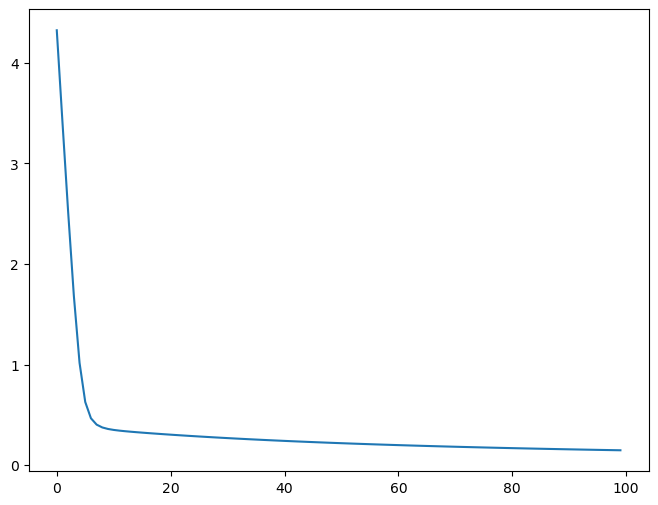

In [59]:
"""
Plot and display the progression of your loss values as a graph. Use the 
provided plotting functions.
"""

#begin_solution
plot_loss_curve(history)
#end_solution


In [60]:
#begin_test

#end_test


**Question 5.b**
<a name='question5b'></a>

Implementation of the Hinge Loss and its gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [61]:
def hinge_loss(z, Y):
    """
    Write your implementation of hinge loss here.

    Arguments:
    z : Classifier score
    Y : Label

    Returns:
    avg : The average hinge loss
    """

    #begin_solution
    loss = 0
    for (index,label) in enumerate(Y):
        loss = loss + max(0, 1-z[index]*Y[index])
    avg = loss/len(Y)
    #end_solution
    
    return avg
  
def dhinge(preds,X, Y, W=[]):
    """
    Implement the derivative of hinge_loss here.

    Arguments:
    preds : The predicted values.
    X : Data matrix
    Y : True Labels
    W : Weights. Optional argument, may/may not be needed, depending on loss function
    Returns:
    J : Gradient of avg hinge_loss with respect to predicted values.
    """
    #begin_solution
    n,m = X.shape
    J = np.zeros(m)
    for (index,est) in enumerate(preds):
        if(est*Y[index]<1):
            for i in range(m):
                J[i] = J[i] + (-1)*X[index,i]*Y[index]
    J = J/n
    
    #end_solution

    
    return J


Implementation of the full gradient descent:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [62]:
"""
After implementing hinge_loss, dhinge and gd, test it below on the IRIS dataset.
"""

#begin_solution
n,m=X_iris.shape
Y_iris_binary_classifier = Y_iris.copy()
for (index,y) in enumerate(Y_iris):
    if(y==0):
        Y_iris_binary_classifier[index] = 1
    else:
        Y_iris_binary_classifier[index] = -1
        

history,best_w = gd(X_iris,Y_iris_binary_classifier,np.random.rand(m+1)-0.5,hinge_loss,dhinge,0.1,100)
sols = predict(X_iris_test,best_w)
print(sols)
print(Y_iris_test)
#end_solution


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

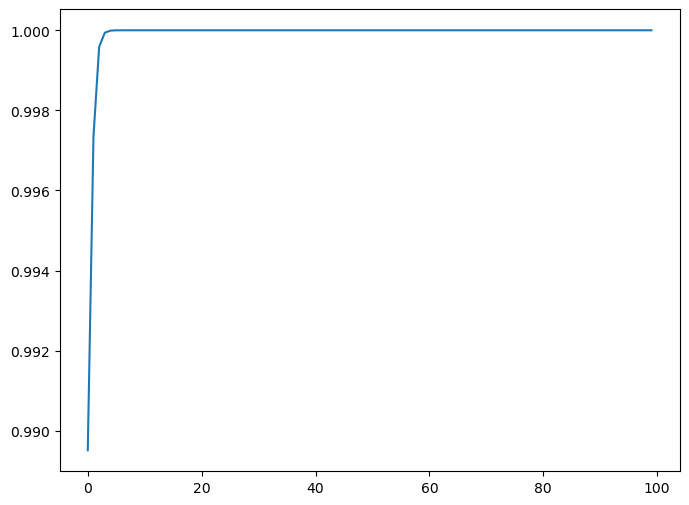

In [63]:
"""
Print the minimum loss
Plot and display the progression of loss. Use provided plotting functions
"""

#begin_solution
plot_loss_curve(history)
#end_solution


In [64]:
#begin_test

#end_test


**Question 5.c**
<a name='question5c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [107]:
def ksvm(kernel, X, Y, X_test):
    """
    Write your implementation of Kernel SVM here.

    Arguments:
    kernel : A callable function that takes 2 samples and returns the score
             for them.
    X : Training data matrix
    Y : Training Labels as -1/1
    X_test : Test data matrix

    Returns:
    support_vectors : The learned support vectors
    preds : The predicted labels as -1/1 on the given Test data
    """
    
    #begin_solution
    XY = X*Y[:,np.newaxis];
    optimal = optimize.minimize(
        fun = lambda a: kernel(X,a),
        x0 = np.ones(X.shape[0]),
        method='SLSQP'
    )
    
    alpha = optimal.x;
    index = alpha>1e-6
    support_vectors = X[index];
    weights = np.sum(alpha[:,np.newaxis]*XY, axis = 0)
    preds = np.dot(X_test, weights);
    for (index,pred) in enumerate(preds):
        if(pred>0):
            preds[index]= -1;
        else:
            preds[index]=1;
    #end_solution


    return support_vectors, preds

In [108]:
X_iris_svm = np.copy(X_iris)
Y_iris_svm = np.copy(Y_iris)
Y_iris_svm[Y_iris==0] = -1
Y_iris_svm[Y_iris!=0] = 1

Y_iris_test_svm = np.copy(Y_iris_test)
Y_iris_test_svm[Y_iris_test==0] = -1
Y_iris_test_svm[Y_iris_test!=0] = 1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

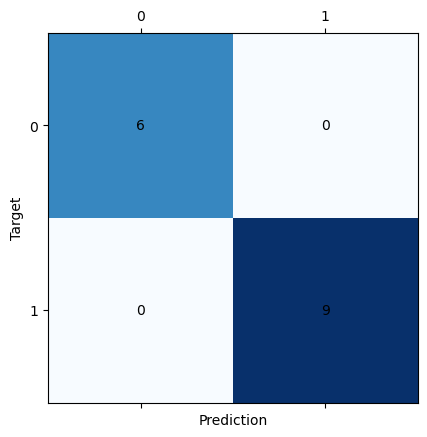

In [109]:
def kernel(x1, x2):
    """
    Define your kernel function here.

    Arguments:
    x1, x2 : Two data samples (vectors)

    Returns:
    score : The score between x1 and x2
    """

    #begin_solution
    score = np.sum((1+np.dot(x1.T,x2))*(1+np.dot(x1.T,x2)));
    #end_solution


    return score

"""
After implementing ksvm and kernel, test it below on the IRIS dataset.
Print the accuracy of the model.
"""

#begin_solution
support_vectors,preds = ksvm(kernel,X_iris_svm,Y_iris_svm,X_iris_test)
plot_confusion_matrix(Y_iris_test_svm,preds)
#end_solution


In [92]:
#begin_test

#end_test


## 6. Neural Networks (20 points)
<a name='question6'></a>

[a)](#question6a) Devise a three-layer neural network with n hidden states and sigmoid activations for classification. Explain how many parameters this has in one sentence. (**2 points**)

[b)](#question6b) Implement the binary classifier nnclass(examplesA, examples, testExamples) that is trained with your implementation of (stochastic) GD and your gradient function using the network. (**5 points** + **7 points** on hidden dataset)

[c)](#question6c) Do an analysis how changes affect the accuracy with _MNIST_. Positive labels are assigned to digit 1 and negative samples to other digits. Write no longer than fifteen sentences. A table and / or plot is welcome. (**6 points**)

**Question 6.a**
<a name='question6a'></a>

_Your reply:_
Considering that then input layer has i neurons(features), the hidden layer has n neurons and the output has o neurons. 
In order to calculate the activations of the n neurons in the hidden layer we need i\*n weights and n biases. In order to go from the hidden layer to the output layer we need n\*o weights and and o biases. In total we have n\*(i+1) + o\*(n+1) parameters

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

**Question 6.b**
<a name='question6b'></a>

In [66]:
def sigmoid(z):
    """
    Write your activation function here.

    Arguments:
    z : Scalar or batch of scalars on which to compute activation(s)

    Returns:
    activation : The activation value(s)
    """

    #begin_solution
    activation = np.exp(z)/(np.exp(z)+1)
    #end_solution


    return activation

def dsigmoid(z):
    """
    Implement the gradient of the activation function.

    Arguments:
    z : Scalar or batch of scalars

    Returns:
    gradient : Gradient(s) of the activation function
    """

    #begin_solution
    gradient = z*(1-z)
    #end_solution


    return gradient

In [67]:
#begin_test

#end_test


Implementation of the forward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [68]:
def forward_pass(x, W, b):
    """
    Write your implementation of forward pass here.

    Arguments:
    x : Input data matrix
    W : Tuple of weight matrices
    b : Tuple of biases

    Returns:
    y_hat : Output of last layer
    cache : A tuple, that contains all intermediate outputs. These will be
            needed in your backward pass. Save anything in cache that you
            plan to use in the backward pass. It should be a tuple
    """

    #begin_solution
    #n,m = x.shape
    x0 = np.ones(1)
    X = np.hstack((x,x0))
    W0 = np.vstack((W[0],b[0]))
    x1 = np.dot(X,W0)
    x1 = sigmoid(x1)
    X1 = np.hstack((x1,x0))
    W1 = np.vstack((W[1],b[1]))
    x2 = np.dot(X1,W1)
    x2 = sigmoid(x2)
    X2 = np.hstack((x2,x0))
    W2 = np.vstack((W[2],b[2]))
    x3 = np.dot(X2,W2)
    y_hat = sigmoid(x3)
    cache = [x1,x2]
    #end_solution


    return y_hat, cache

#begin_test

#end_test


Implementation of the loss and its associated gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [69]:
def loss(preds, targets):
    """
    Write your loss function here.

    Arguments:
    preds: The network predictions
    targets: The true labels

    Returns:
    cost: An error metric between pred and targets
    """

    #begin_solution
    cost=0
    for (index,prediction) in enumerate(preds):
        cost = cost - targets[index]*np.log(prediction) - (1-targets[index])*(1-np.log(prediction))
    #end_solution

    
    return cost

def dloss(preds, target):
    """
    Write the derivative of loss function here.

    Arguments:
    preds : The network predictions
    target : The true labels

    Returns:
    gradient : The derivative of loss function with respect to the
              network outputs
    """

    #begin_solution
    #end_solution


    return gradient

In [70]:
#begin_test

#end_test


Implementation of the backward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [71]:
def backward_pass(preds, targets, W, b, X, cache):
    """
    Write your implementation of backward_pass here.

    Arguments:
    preds : The network predictions
    targets : The true labels
    W : A tuple of weight matrices
    b : A tuple of bias values
    X : Input data matrix
    cache : Tuple of Intermediate outputs that you cached in forward_pass

    Returns:
    Gradients with respect to each layer's weights and biases
    """
    #begin_solution
    error_3 = (preds[0]-targets) * dsigmoid(preds[0])
    error_2 = (W[2] * error_3).T * dsigmoid(cache[1])
    error_1 = np.dot(W[1],error_2.T).T * dsigmoid(cache[0])
    #error_0 = np.dot(W[0],error_1) * dsigmoid()
    #end_solution
    J_w1 = np.dot(np.array([X]).T,error_1)
    J_b1 = error_1
    #print(J_w1.shape)
    #print(J_b1.shape)
    J_w2 = np.dot(np.array([cache[0]]).T,error_2)
    J_b2 = error_2
    #print(J_w2.shape)
    #print(J_b2.shape)
    J_w3 = np.dot(np.array([cache[1]]).T,error_3)
    J_b3 = error_3
    #print(J_w3.shape)
    #print(J_b3.shape)
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [72]:
def training(X, Y, W, b, step_size, max_it):
    """
    Implement your training loop here.

    Arguments:
    X : Input Data matrix
    Y : True labels
    W : A tuple of weight matrices
    step_size : The step size to take for network updates
    max_it : The maximum iterations after which to stop

    Returns:
    W : The trained weights
    b : The trained biases
    history : A list of your loss values at each iteration
    """
    
    #begin_test

    #end_test

    
    #begin_solution
    history = np.zeros(max_it);
    for iteration in range(max_it):
        #total_error = 0
        n,m =X.shape
        y_hat = np.zeros(n)
        for (index,entry) in enumerate(X):
            yhat,cache = forward_pass(entry,W,b)
            #print(yhat,Y[index])
            J_w3,J_w2,J_w1,J_b3,J_b2,J_b1 = backward_pass(yhat,Y[index],W,b,entry,cache)
            W[0] = W[0] - step_size*J_w1
            W[1] = W[1] - step_size*J_w2 
            W[2] = W[2] - step_size*J_w3 
            b[0] = b[0] - step_size*J_b1
            b[1] = b[1] - step_size*J_b2 
            b[2] = b[2] - step_size*J_b3 
            #total_error = total_error + sum([(yhat[i]-Y[i])**2 for i in range(len(Y))])
            #print(iteration,index)
            for(index, entry) in enumerate(X):
                yhat,cache = forward_pass(entry,W,b);
                y_hat[index]=yhat;
            #y_hat[index]=yhat
            #print(y_hat[:10])
        #total_error = total_error / n
        total_error = loss(yhat,Y)
        #print(total_error)
        #print(W[0])
        #print(W[1])
        #print(W[2])
        #print(b[0])
        #print(b[1])
        #print(b[2])
        history[iteration]=total_error;
    #print(Y[:10])
    for(index, entry) in enumerate(X):
        yhat,cache = forward_pass(entry,W,b);
        y_hat[index]=yhat;
    #end_solution

    
    #begin_test

    #end_test

            
    return W, b, history

In [73]:
#begin_test

#end_test


In [ ]:
"""
Below, initialize the weights and biases randomly.
Start your training loop with your choice of parameters step_size, max_it
"""

#begin_solution
n,m = X_mnist.shape
W0 = np.random.rand(m,10) - 0.5
W1 = np.random.rand(10,10) - 0.5 
W2 = np.random.rand(10,1) - 0.5
b0 = np.random.rand(1,10) - 0.5 
b1 = np.random.rand(1,10) - 0.5
b2 = np.random.rand(1,1) - 0.5
W=[W0,W1,W2]
b=[b0,b1,b2]
Y_mnist_modified = Y_mnist.copy()
for (index,y) in enumerate(Y_mnist):
    if(y!=1):
        Y_mnist_modified[index] = -1

W,b,history = training(X_mnist,Y_mnist_modified,W,b,0.1,1000)
#end_solution


#training(np.array([[1,2,3],[2,4,100]]),np.array([1,0]),W,b,0.1,1000)

**Question 6.c**
<a name='question6d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_
As designers of the Neural Network we can modify two main things: a) the amount of nodes in the hidden layers, and b) the amount of hidden layers. These all increase the dimension of the weight matrices and may lead to better results, but also there are 2 disadvantages: 1) Training time takes longer (there are more parameters to optimise, all our matrices are greater and therefore the operations take longer), and 2) there is a higher change of overfitting -> the network only recognizes the training data, rather then learning the underlying information.
Given enough training time and computational power, we can try to sweep through values of the number of neurons/layer and plot a graph that shows the loss, and finally choose the value that gives the best loss.
Also, when working with known datasets we can improve accuracy by other methods, not related to neural networks directly, such as statistical methods. We can also run different CNN's( with different structure) and choose the result that appeared the most often.

In [ ]:
#begin_test

#end_test
